# The Wright Fisher Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import panel as pn


sns.set()

Imagine a population of $N$ individuals, in which an individual consists of a single locus, and there are two alleles for that locus, $A$ and $B$. Here we are going to work through the **Wright-Fisher model**, in which we assume a fixed generation time (no overlapping generations). At each timestep we sample the new generation from the previous one, where the number of individuals is constant. The number of individuals for allele $A$ is denoted by $N_A$ and the relative number of individuals, also called frequency, is denothed by $x_A = N_A/(N_A + N_B)$. For each offspring in the new generation, we randomly choose an ancestor. What is the chance of choosing a certain individual? It is just the relative abundance! Therefore, we can write the probability for choosing allele $A$ as $p_A = x_A$.

## Genetic Drift 

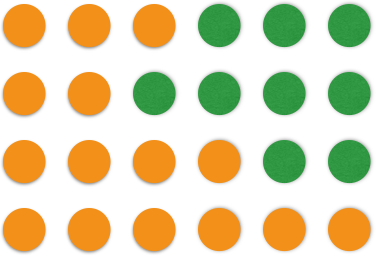

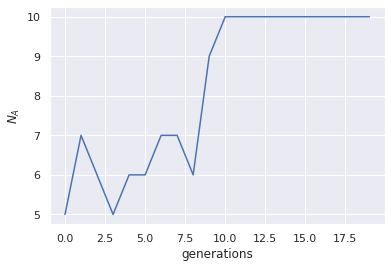

In [2]:
# Total Population Size
N = 10

# Initial species size of allele A
N_A_0 = 5

# Number of generations
time_points = 20

# Array to store species sice at each generation
N_t = np.zeros(time_points)

# Set size for first generation
N_t[0] = N_A_0

# Iterate through generations
for i in range(1, time_points):
  # Compute frequency of allele A
  p = N_t[i-1] / N
  # Draw N random numbers and find the ones that are smaller than p
  N_A = np.random.rand(N) < p
  # Find species size of allele A
  N_t[i] = np.sum(N_A)
  

# Plot trajectory
plt.plot(N_t)
plt.xlabel("generations")
plt.ylabel(r"$N_A$");

It is hard to draw any conclusions from a single trajecory. Therefore we will look at a bunch of trajectories and try to identify a general behavior. To do that, we write a function that return a single trajectory, and then run that function many times.

In [3]:
def drift(time_points=20, N=10, N_A_0=5):
  N_t = np.zeros(time_points)
  N_t[0] = N_A_0

  for i in range(1, time_points):
    p = N_t[i-1] / N
    N_A = 0
    for j in range(N):
      if np.random.rand() < p:
        N_A += 1
    N_t[i] = N_A

  return N_t / N

Now we can run the function. To display the results, we will plot every trajectory with increased transparency to not clutter the plot too much. Let's also plot the mean frequency at each point in time in order to get an idea of the trajectories behave on average. Another summary plot we can do is to look at the distribution of end points.

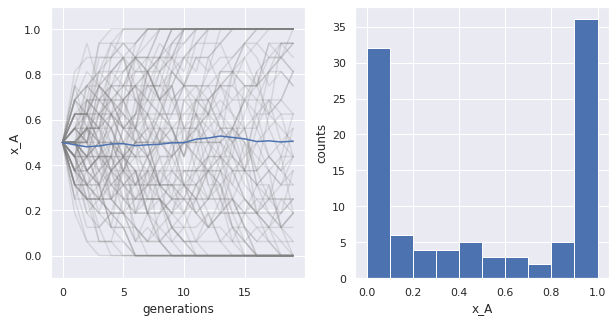

In [4]:
# Initialize canvas
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Annotate plot for trajectories
ax[0].set_xlabel("generations")
ax[0].set_ylabel("x_A")
ax[0].set_ylim(-0.1, 1.1)

# Annotate plot for distributions for end points
ax[1].set_ylabel("counts")
ax[1].set_xlabel("x_A")

# Set parameters
N = 16
N_A_0 = 8
time_points = 20

# Set number of trajectories
iterations = 100
# Create array to store trajectories
trajectories = np.zeros((iterations, time_points))

# Run function for each trajectory
for i in range(iterations):
  # Get trajectory
  trajectories[i, :] = drift(N=N, N_A_0=N_A_0, time_points=time_points)
  # Plot trajectory
  ax[0].plot(range(time_points), trajectories[i, :], color="gray", alpha=0.2)

# Compute mean frequency at each time point
mean_trajectory = np.mean(trajectories, axis=0)

# plot mean trajectory
ax[0].plot(range(time_points), mean_trajectory)
# Plot histogram 
ax[1].hist(trajectories[:, -1], range=(0, 1));

Here we can see that if we run the simulation for enough generations, every trajectory will hit a boundary of either extinction ($x_A=0$) or fixation ($x_A=1$). Once the trajectory hits a boundary, it will stay there forever, since a new generation can only be sampled from a single allele.

## Genetic Drift and Selection

So far we have considered two alleles that only differ by a label. Now we will include a difference in growth rate, which is also called a difference in fitness. This biases the probability for choosing an allele based on its fitness, it is more likely that the allele with more fitness will produce more offspring. Therefore, we modify the probability of choosing allele A to $p_A=x_A \exp\left[f_a - \bar{f}\right] / Z$, where $\bar{f}$ is the mean fitness, $\bar{f} = x_A f_A + x_B f_B$ and $Z$ is a normalization constant, $Z = x_A \exp\left[f_a - \bar{f}\right] + x_B \exp\left[f_B - \bar{f}\right]$.

In [5]:
def drift_selection(f_A, f_B, time_points=20, N=10, N_A_0=5):
  # Create array for populaition over time
  N_t = np.zeros((time_points, N))
  # Set inital generation
  N_t[0, :N_A_0] = 1
  # Go through generations
  for i in range(1, time_points):
    # Compute frequency pressure
    x = np.sum(N_t[i-1, :]) / N
    # Compute mean fitness
    fbar = x * f_A + (1-x) * f_B
    # Compute reproduction probality
    p = x * np.exp(f_A - fbar) / (x * np.exp(f_A - fbar) + (1 - x) * np.exp(f_B-fbar))
    # Generate next generation
    N_t[i, :] = np.random.rand(N) < p
  
  # return population in terms of frequency at each generation
  return np.sum(N_t, axis=1) / N

Again let's look at a single trajectory first.

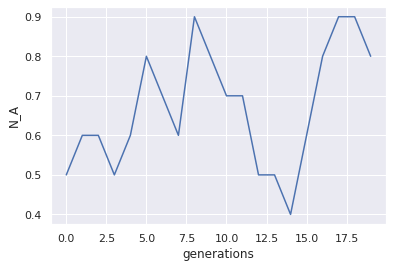

In [6]:
# Create plotting canvas
fig, ax = plt.subplots()

# Label plot
ax.set_xlabel("generations")
ax.set_ylabel("N_A")

# Set fitness values
f_A = 1
f_B = 1.01

# Set population size
N = 10
N_A_0 = 5

# Set generations
time_points = 20

# Compute single trajectory
trajectory =  drift_selection(f_A, f_B, N=N, N_A_0=N_A_0, time_points=time_points)

# Plot trajectory
ax.plot(range(time_points), trajectory);

As we have seen in the drift only case, it is impossible to draw many conclusions from a single trajectory. Hence, we'll again plot a bunch of curves and look at how the mean evolves over time.

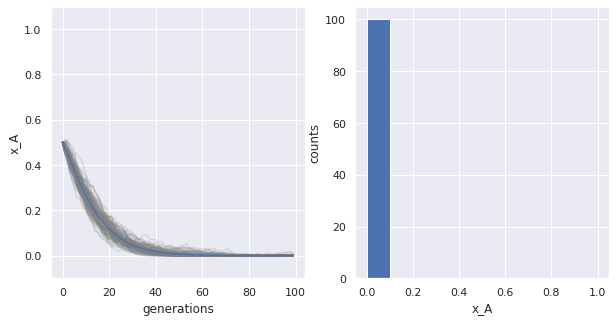

In [7]:
# Create canvas
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Add axis labels for trajectories
ax[0].set_xlabel("generations")
ax[0].set_ylabel("x_A")
ax[0].set_ylim(-0.1, 1.1)

# Add axis labels for distribution
ax[1].set_ylabel("counts")
ax[1].set_xlabel("x_A")

# Fitness
f_A = 1
f_B = 1.1

# Population size
N = 1000
N_A_0 = 500

# Generations
time_points = 100

# Number of trajectories
iterations = 100

# Array to store trajectories
trajectories = np.zeros((iterations, time_points))

# Compute and plot trajectories
for i in range(iterations):
  trajectories[i, :] = drift_selection(f_A, f_B, N=N, N_A_0=N_A_0, time_points=time_points)
  ax[0].plot(range(time_points), trajectories[i, :], color="gray", alpha=0.2)

# Compute mean trajectory
mean_trajectory = np.mean(trajectories, axis=0)

# Plot mean trajectory
ax[0].plot(range(time_points), mean_trajectory)

# Plot histogram
ax[1].hist(trajectories[:, -1], range=(0, 1));

For this problem we can compute an analytical solution! Assuming exponential growth, we already know how to write down the time derivative for the species size, $\frac{d}{dt} N_A(t) = f_A N_A$, where we call $f_A$ the _Malthusian_ fitness of allele A. Note that the time evolution of the total population is $$\frac{d}{dt} N(t) = \frac{d}{dt} N_A(t) + \frac{d}{dt} N_B(t) = f_A N_A + f_B N_B = N\left(f_A x_A + f_B x_B\right) = \bar{f} N.$$
Now we can write the time evolution of allele A in terms of its frequency, $$\frac{d}{dt} x_A(t) = \frac{d}{dt}\left(\frac{N_A(t)}{N(t)}\right) = \frac{1}{N(t)}\frac{d}{dt}N_A(t) - \frac{N_A(t)}{N(t)^2}\frac{d}{dt}N(t),$$ which we can simplify to
$$\frac{d}{dt} x_A(t) = (f_A - \bar{f}) x_A,$$
This expression looks quite simple, but don't forget that the mean fitness depends on the frequency of allele A as well! So let's tackle that issue by inserting the expression for $\bar{f}$ and also using the fact that frequencies are normalized $1=x_A + x_B$ and we can write the frequency of allele B in terms of the frequency of allele A, $x_A = 1 - x_B$. Finally, we get the growth law for the frequency of allele A as 
$$\frac{d}{dt} x_A(t) = f_A \ x_A(1-x_A). $$
This differential equation has the solution
$$ x_A(t) = \frac{x_A(0)e^{(f_A-f_B)t}}{1 + x_A(0)\left(e^{(f_A-f_B)t} - 1\right)}.$$


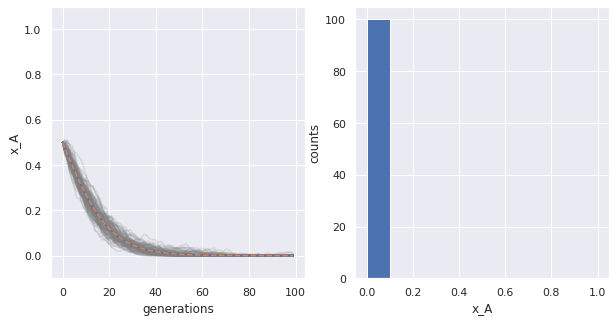

In [8]:
def selection_deterministic(x_0, s, times, N):
  return [x_0 * np.exp(s * t) / (1 + x_0 * (np.exp(s * t) - 1)) for t in times] 


s = (f_A - f_B)
det_sol = selection_deterministic(N_A_0 / N, s, range(time_points), N) 
ax[0].plot(range(time_points), det_sol, '--')
fig

## Genetic Drift + Selection + Mutations

So far trajectories that have hit the boundaries of extinction or fixation were stuck for the end of time, since there was no way for allele A to change to allele B. This job is done by mutations, where we can observe spontaneous changes between alleles. We assume that mutations happen at a rate $\mu$, which is given as the rate per individual and per generation. In an ideal case, we find a way to do the mutations without having to go through every single individual. Therefore, let's find a function that does the mutation for us. Turns out that we can write $y = \delta_\mu (1 - 2y) + y$ where $y$ is the identity of the individual, and $\delta_\mu$ is 1 if that individual mutates. Try it out!

In [9]:
def drift_selection_mutation(f_A, f_B, mu, time_points=20, N=10, N_A_0=5):
  # Array to store trajectories
  N_t = np.zeros((time_points, N))
  # Store first generation
  N_t[0, :N_A_0] = 1

  # Iterate through generations
  for i in range(1, time_points):
    # Compute frequency of allele A
    x = np.sum(N_t[i-1, :]) / N
    # Compute mean fitness
    fbar = x * f_A + (1-x) * f_B
    # Reproduction probability for allele A
    p = x * np.exp(f_A - fbar) / (x * np.exp(f_A - fbar) + (1 - x) * np.exp(f_B-fbar))
    # Sample next generation
    N_t[i, :] = np.random.rand(N) < p
    # Find mutants
    mu_arr = np.random.rand(N) < mu
    # Mutate
    N_t[i, :] = mu_arr *(1 - 2 * N_t[i, :]) + N_t[i, :]
    
  return np.sum(N_t, axis=1) / N

Again, let's have a look at a single trajectory. 

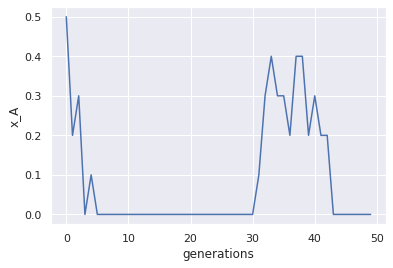

In [10]:
# Create canvas
fig, ax = plt.subplots()

# set label for axis
ax.set_xlabel("generations")
ax.set_ylabel("x_A")

# fitness
f_A = 1
f_B = 1.01

# population size
N = 10
N_A_0 = 5

# Mutation rate
mu = 0.01
# Generations
time_points = 50

# Compute and plot trajectory
trajectory =  drift_selection_mutation(f_A, f_B, mu, N=N, N_A_0=N_A_0, time_points=time_points)
ax.plot(range(time_points), trajectory);

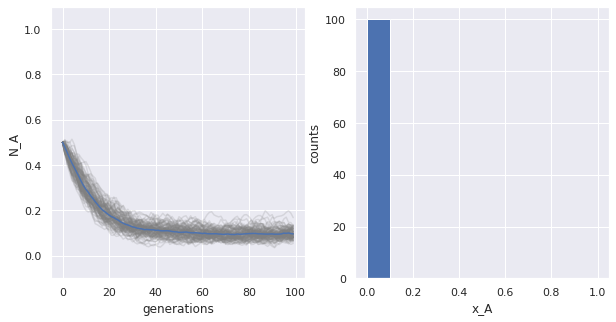

In [11]:
# Create Canvas
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Label axis
ax[0].set_xlabel("generations")
ax[0].set_ylabel("N_A")
ax[0].set_ylim(-0.1, 1.1)

ax[1].set_ylabel("counts")
ax[1].set_xlabel("x_A")

# Fitness
f_A = 1
f_B = 1.1

# Population size
N = 1000
N_A_0 = 500

# Mutation rate
mu = 0.01

# Generations
time_points = 100
# Number of trajectories
iterations = 100
# Array to store trajectories
trajectories = np.zeros((iterations, time_points))

# Compute and plot trajectories
for i in range(iterations):
  trajectories[i, :] = drift_selection_mutation(f_A, f_B, mu, N=N, N_A_0=N_A_0, time_points=time_points)
  ax[0].plot(range(time_points), trajectories[i, :], color="gray", alpha=0.2)

# Compute mean trajectory
mean_trajectory = np.mean(trajectories, axis=0)

# Plot mean trajectory and histogram
ax[0].plot(range(time_points), mean_trajectory)
ax[1].hist(trajectories[:, -1]/N, range=(0, 1));

In [12]:
# 